In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.dates as mdts
import matplotlib.pyplot as plt
import mpl_toolkits as mpltk
from geopy.distance import vincenty
import cartopy.crs as ccrs

In [2]:
# incidents data reading
incdnt_file_name = '../data/PeMS/Incidents/all_text_chp_incident_day_2017_10_11.txt'
inc_header = ['IncidentID', 'CC_Code', 'Incident_No', 'Timestamp', 'Description', 'Location', 'Area', 'Zoom_Map', 'TBxy', 'Latitude', 'Longitude', 'District', 'CountryFIPS_ID', 'CityFIPS_ID', 'Freeway', 'Freeway_direction', 'State_postmile', 'Absolute_postmile', 'Severity', 'Duration', 'Incident_ID', 'Detail_ID', 'Timestamp', 'description']
data_inc = pd.read_csv(incdnt_file_name, sep=',', names=inc_header, parse_dates=[3])
data_inc = (data_inc.dropna(subset=['District']))[data_inc.columns[:-4]]
data_inc = data_inc.astype(dtype={'District':int})
# result: incidents in district under analysis
data_inc_d07 = data_inc[data_inc['District']==7].copy().reset_index()

In [3]:
def filter_by_param(data, param_name, param_val):
    return data[data[param_name] == param_val].copy()


In [4]:
# traffic flow data reading
header = ['Timestamp', 'Station','District', 'Freeway', 'Direction of Travel', 'Lane Type', 'Station Length',
          'Samples', '% Observed', 'Total Flow', 'Avg Occupancy', 'Avg Speed', 
          'Lane 1 Samples', 'Lane 1 Flow', 'Lane 1 Avg Occ', 'Lane 1 Avg Speed', 'Lane 1 Observed',
          'Lane 2 Samples', 'Lane 2 Flow', 'Lane 2 Avg Occ', 'Lane 2 Avg Speed', 'Lane 2 Observed',
          'Lane 3 Samples', 'Lane 3 Flow', 'Lane 3 Avg Occ', 'Lane 3 Avg Speed', 'Lane 3 Observed',
          'Lane 4 Samples', 'Lane 4 Flow', 'Lane 4 Avg Occ', 'Lane 4 Avg Speed', 'Lane 4 Observed',
          'Lane 5 Samples', 'Lane 5 Flow', 'Lane 5 Avg Occ', 'Lane 5 Avg Speed', 'Lane 5 Observed',
          'Lane 6 Samples', 'Lane 6 Flow', 'Lane 6 Avg Occ', 'Lane 6 Avg Speed', 'Lane 6 Observed',
          'Lane 7 Samples', 'Lane 7 Flow', 'Lane 7 Avg Occ', 'Lane 7 Avg Speed', 'Lane 7 Observed',
          'Lane 8 Samples', 'Lane 8 Flow', 'Lane 8 Avg Occ', 'Lane 8 Avg Speed', 'Lane 8 Observed']

srs_file_name = '../data/PeMS/Series/d07_text_station_5min_2017_10_11.txt'
data_srs = pd.read_csv(srs_file_name, sep=',', names=header, parse_dates=[0])
data_wo_lanes = data_srs[data_srs.columns[:-40]].copy()

In [5]:
file_stations = '../data/PeMS/Stations/d07_text_meta_2017_09_20.txt'
header = ['ID', 'Freeway', 'Freeway dir', 'Country', 'City', 'State Postmile', 'Abs Postmile', 
          'Latitude', 'Longitude', 'Length', 'Type', 'Lanes', 'Name',
          'User ID1', 'User ID2', 'User ID3', 'User ID4']
stations_d07 = pd.read_csv(file_stations, sep='\t')
stations_d07 = stations_d07.astype({'Latitude':float, 'Longitude':float})
stations_d07_nona = stations_d07.dropna(subset=['Latitude', 'Longitude']).copy().reset_index(drop=True)
# result: non-empty speed data series  only, stations which provide these data
data_srs_no_null = data_srs.dropna(subset=['Lane 1 Avg Speed'])
stations_active = stations_d07_nona[stations_d07_nona['ID'].isin(data_srs_no_null['Station'].unique())].copy().reset_index(drop=True)

In [6]:
def drop_nulls_column(data, c_name):
    return data.dropna(subset=[c_name])

In [7]:
def plot_flow_w_incidents(flow_data, incdnt_data, frw_no, station_no, chrstc_to_plot = 'Lane 1 Avg Speed'):
    hours = mdts.HourLocator()
    datemin = dt.datetime(year=2017, month=10, day=11, hour=8)
    datemax = dt.datetime(year=2017, month=10, day=11, hour=20)
    data_srs_no_null = flow_data.dropna(subset=[chrstc_to_plot])
    data_incdnts_by_frw = incdnt_data[incdnt_data['Freeway']==frw_no]
    dates = data_srs_no_null[(data_srs_no_null['Freeway'] == frw_no) & (data_srs_no_null['Station'] == station_no)]['Timestamp']
    speed = data_srs_no_null[(data_srs_no_null['Freeway'] == frw_no) & (data_srs_no_null['Station'] == station_no)][chrstc_to_plot]
    fig,ax = plt.subplots(figsize=[15,10])
    fig.figsize = [15,10]
    plt.plot_date(dates, speed, fmt='-', tz='EST')
    for x in data_incdnts_by_frw['Timestamp']:
        plt.axvline(x)
    ax.xaxis.set_major_locator(hours)
    fig.autofmt_xdate()
    ax.xaxis.set_major_formatter(mdts.DateFormatter('%H:%M'))
    ax.set_xlim(datemin, datemax)
    plt.grid()
    plt.show()

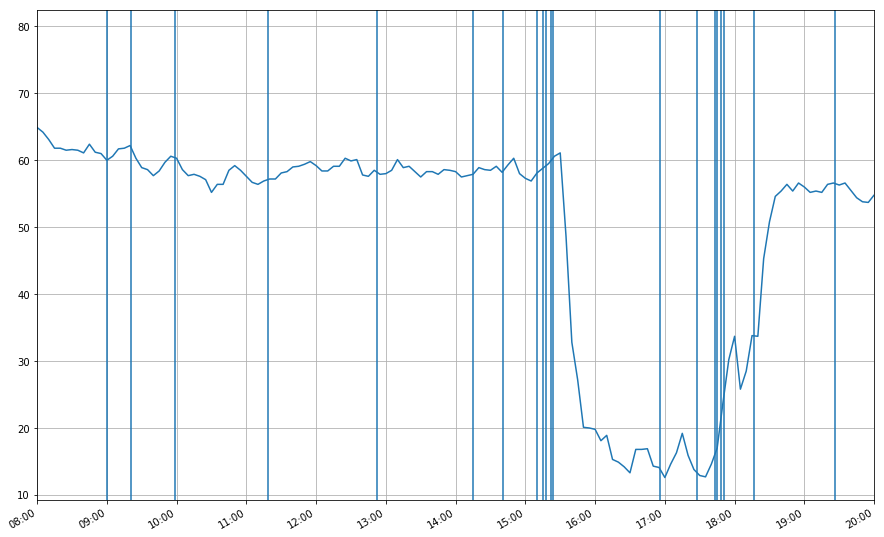

In [8]:
plot_flow_w_incidents(data_srs, data_inc_d07, 101, 716328)

In [9]:
def show_unique_freeways(data):
#     result = np.empty([0,len(data.columns)])
    maximum=0
    for st in data['Station'].unique():
#         result = np.append(result, data[data['Station'] == st])
        crnt_len = len(data[data['Station'] == st]['Freeway'].unique())
        if crnt_len > maximum:
            maximum = crnt_len
    return maximum

In [10]:
print(show_unique_freeways(data_wo_lanes))

1


In [11]:
min_lon = stations_d07['Longitude'].min()
max_lon = stations_d07['Longitude'].max()
min_lat = stations_d07['Latitude'].min()
max_lat = stations_d07['Latitude'].max()

In [12]:
st1_coords = (stations_d07['Latitude'][0], stations_d07['Longitude'][0])
st2_coords = (stations_d07['Latitude'][1], stations_d07['Longitude'][1])
st1_coords_ccrs = [stations_d07['Latitude'][0], stations_d07['Longitude'][0]]

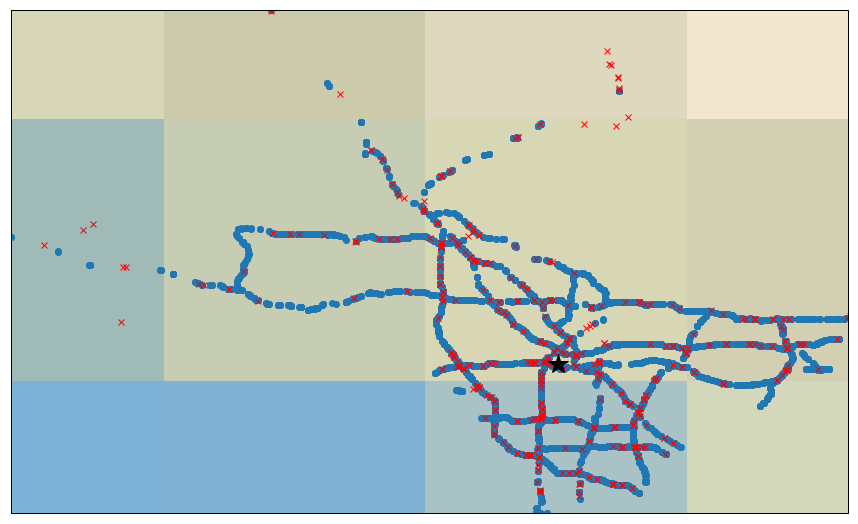

In [13]:
fig = plt.figure(figsize=[15,10])
ax = fig.gca(projection=ccrs.PlateCarree())
ax.stock_img()
plt.plot(stations_d07_nona['Longitude'], stations_d07_nona['Latitude'], transform=ccrs.PlateCarree(), marker='o', linestyle='')
plt.plot(data_inc[data_inc['District']==7]['Longitude'], data_inc[data_inc['District']==7]['Latitude'], marker='x', color='red', linestyle='')
plt.plot(data_inc[data_inc['District']==7]['Longitude'].mean(), data_inc[data_inc['District']==7]['Latitude'].mean()-.05, marker='*', markersize=20, color='black', linestyle='')
# ax.set_xlim()
# ax.set_extent((min_lon-10, max_lon+10, min_lat-10, max_lat+10))
ax.set_extent((min_lon, max_lon, min_lat, max_lat))
plt.show()

In [14]:
most_accidentious_spot = [data_inc[data_inc['District']==7]['Latitude'].mean(), data_inc[data_inc['District']==7]['Longitude'].mean()-.05]
min_dist = 100 
limit_i=100000
for i in range(stations_d07_nona.shape[0]):
    st_coords = [stations_d07_nona['Latitude'][i], stations_d07_nona['Longitude'][i]]
#     print(st_coords)
    crnt_dist = vincenty(most_accidentious_spot, st_coords).kilometers
    if crnt_dist < min_dist:
        min_dist = crnt_dist
        index=i
    if i>limit_i:
        break
print('From hot spot to the closest station {0:.3f} km'.format(min_dist))
print('Station closest to hot spot {} (ID={})'.format(index, stations_d07_nona.loc[index]['ID']))

From hot spot to the closest station 0.095 km
Station closest to hot spot 1274 (ID=717459)


In [15]:
stations_d07_nona[stations_d07_nona.apply(lambda x: vincenty((x['Latitude'], x['Longitude']), most_accidentious_spot).kilometers < 1, axis=1)].shape

(11, 18)

In [16]:
def plot_station_data_w_nearest_incds(flow_data, incdnt_data, stations_data, station_no, vicinity_km, chrstc_to_plot = 'Lane 1 Avg Speed'):
    hours = mdts.HourLocator()
    datemin = dt.datetime(year=2017, month=10, day=11, hour=7)
    datemax = dt.datetime(year=2017, month=10, day=11, hour=22)
    # filter only data for one station and w/o nans
    data_srs_no_null = flow_data[flow_data['Station'] == station_no]
    data_srs_no_null = data_srs_no_null.dropna(subset=[chrstc_to_plot])
    # station of interest coords
    station_coords = np.asarray(stations_data[stations_data['ID'] == station_no][['Latitude', 'Longitude']])
    # incidents closest to the station
    data_incdnts_nearest = incdnt_data[incdnt_data.apply(lambda x: vincenty((x['Latitude'], x['Longitude']), station_coords).kilometers < vicinity_km, axis=1)]
    # x-values
    dates = data_srs_no_null['Timestamp']
    # y-values
    speed = data_srs_no_null[chrstc_to_plot]
    fig,ax = plt.subplots(figsize=[15,10])
    fig.figsize = [15,10]
    plt.plot_date(dates, speed, fmt='-', tz='EST')
    for x in data_incdnts_nearest['Timestamp']:
        plt.axvline(x)
    ax.xaxis.set_major_locator(hours)
    fig.autofmt_xdate()
    ax.xaxis.set_major_formatter(mdts.DateFormatter('%H:%M'))
    ax.set_xlim(datemin, datemax)
    plt.grid()
    plt.show()

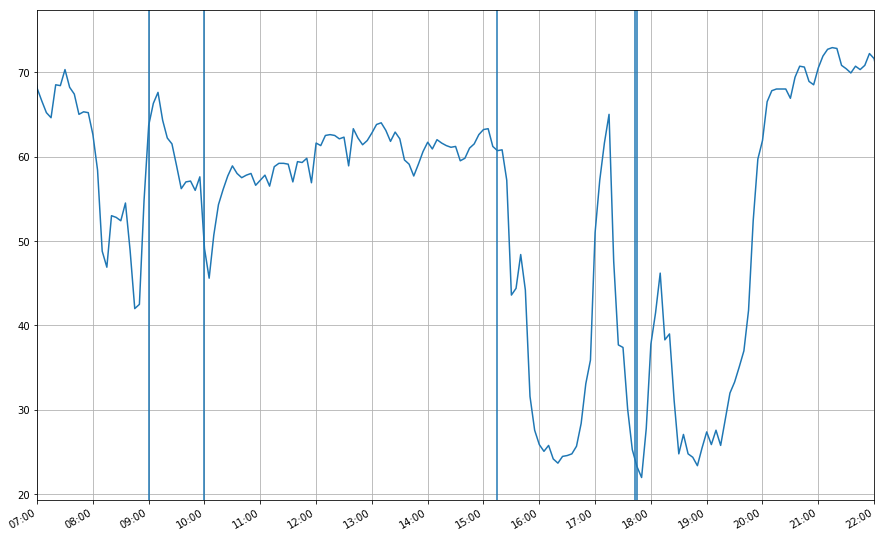

In [17]:
plot_station_data_w_nearest_incds(data_srs, data_inc, stations_active, 717459, vicinity_km=3)

##  Analysis of incidents impact

In [18]:
def isImpacted(srs, ts, ticks_to_count=3):
    srs_b4 = srs[srs['Timestamp'] < ts].sort_values(by='Timestamp', ascending=True).iloc[-ticks_to_count:]
    srs_after = srs[srs['Timestamp'] > ts].sort_values(by='Timestamp', ascending=True).iloc[:ticks_to_count]
    if(srs_b4['Lane 1 Avg Speed'].mean() > srs_after['Lane 1 Avg Speed'].mean()):
        return True
    return False
isImpacted_vec = np.vectorize(isImpacted, excluded=[1,2])

In [19]:
def return_station_series(srs, station):
    return srs[srs['Station']==station]
return_station_series_vec = np.vectorize(return_station_series, excluded=[0])

In [70]:
stations_active[stations_active['Dir']=='S'].head()

,ID,Fwy,Dir,District,County,City,State_PM,Abs_PM,Latitude,Longitude,Length,Type,Lanes,Name,User_ID_1,User_ID_2,User_ID_3,User_ID_4
0,715898,5,S,7,37,40032.0,.71,117.28,33.880183,-118.021787,0.430,ML,3,PHOEBE,2029,NaN,NaN,NaN
2,715920,5,S,7,37,52526.0,6.64,123.21,33.938544,-118.094941,1.290,ML,4,S OF 605,2296,NaN,NaN,NaN
3,715929,5,S,7,37,19766.0,9.5,126.07,33.971707,-118.123095,0.470,ML,4,GUATEMALA,2023,NaN,NaN,NaN
8,715947,5,S,7,37,14974.0,13.67,130.24,34.015325,-118.171270,0.495,ML,3,S OF 710,2536,NaN,NaN,NaN
9,715996,5,S,7,37,44000.0,37.3,153.87,34.243318,-118.421080,0.275,ML,6,OSBORNE 1,3486,NaN,NaN,NaN


In [72]:
tinc = data_inc_d07.iloc[6]

In [73]:
tinc['Latitude']

34.020495000000004

In [82]:
tst = stations_active[stations_active['Dir'] == tinc['Freeway_direction']]

In [94]:
filter_proper_direction(tinc, stations_active)

,ID,Fwy,Dir,District,County,City,State_PM,Abs_PM,Latitude,Longitude,Length,Type,Lanes,Name,User_ID_1,User_ID_2,User_ID_3,User_ID_4
9,715996,5,S,7,37,44000.0,37.3,153.870,34.243318,-118.421080,0.275,ML,6,OSBORNE 1,3486,NaN,NaN,NaN
11,716010,5,S,7,37,69088.0,R49.5,165.847,34.368149,-118.558850,0.600,ML,4,S OF WABUSKA,2089,NaN,NaN,NaN
12,716016,5,S,7,37,69088.0,R54.2,170.547,34.431273,-118.588555,0.650,ML,4,RYE CANYON,4379,NaN,NaN,NaN
59,716271,71,S,7,37,58072.0,R.84,0.501,34.067080,-117.804144,1.218,ML,1,RIDGEWAY ST,2560,NaN,NaN,NaN
68,716328,101,S,7,37,44000.0,2.08,3.428,34.067067,-118.254688,0.365,ML,4,EDGEWARE,2076,NaN,NaN,NaN
69,716331,101,S,7,37,44000.0,2.56,3.908,34.070002,-118.262279,0.355,ML,4,GLENDALE,3004,NaN,NaN,NaN
71,716339,101,S,7,37,44000.0,4.2,5.548,34.078365,-118.288977,0.525,ML,4,VERMONT,3002,NaN,NaN,NaN
73,716390,101,S,7,37,90310.0,29.5,30.832,34.149135,-118.672472,0.790,ML,5,CALABASAS,2634,NaN,NaN,NaN
74,716391,101,S,7,37,90310.0,30,31.332,34.151032,-118.680765,0.760,ML,4,TRUCK STOP,2635,NaN,NaN,NaN
75,716392,101,S,7,37,90310.0,31.02,32.352,34.148836,-118.697394,0.600,ML,4,LAS VIRGENES 1,4176,NaN,NaN,NaN


In [86]:
def filter_proper_direction(incident, stations):
    target_stations = stations[stations['Dir']==incident['Freeway_direction']]
    if incident['Freeway_direction'] == 'N':
        target_stations = target_stations[target_stations['Latitude']<incident['Latitude']]
    elif incident['Freeway_direction'] == 'E':
        target_stations = target_stations[target_stations['Longitude']<incident['Longitude']]
    elif incident['Freeway_direction'] == 'S':
        target_stations = target_stations[target_stations['Latitude']>incident['Latitude']]
    elif incident['Freeway_direction'] == 'W':
        target_stations = target_stations[target_stations['Longitude']>incident['Longitude']]
    return target_stations

In [20]:
def get_stations_within_inc_vicinity(incident, stations, vicinity):
    inc_loc = np.asarray(incident[['Latitude', 'Longitude']])
    return stations[stations.apply(lambda x: vincenty((x['Latitude'], x['Longitude']), inc_loc).kilometers < vicinity, axis=1)]

In [109]:
ttst = get_stations_within_inc_vicinity(tinc, stations_active,1)

In [110]:
ttst.shape

(4, 18)

In [105]:
type(ttst)

pandas.core.frame.DataFrame

In [111]:
def calculate_affect_degree(incidents, series, stations, radius):
    impact = np.array([])
    for crnt_inc in incidents.iterrows():
        target_stations = filter_proper_direction(crnt_inc[1], stations)
        if target_stations.size == 0:
            impact = np.append(impact,-1.0)
            continue
        crnt_vcnt_st = get_stations_within_inc_vicinity(crnt_inc[1], target_stations, radius)  
        if crnt_vcnt_st.size == 0:
            impact = np.append(impact,-1.0)
            continue
        series_in_quest = return_station_series_vec(series, crnt_vcnt_st['ID'])
        impacted_result = isImpacted_vec(series_in_quest, crnt_inc[1]['Timestamp'], 3)
        prcnt = impacted_result.sum()/impacted_result.shape[0]
        impact = np.append(impact,prcnt)
    return impact

In [99]:
impact_km = calculate_affect_degree(data_inc_d07.iloc[:20], data_srs_no_null, stations_active, 1)

In [100]:
impact_km

array([ 0.5       ,  0.        , -1.        , -1.        , -1.        ,
       -1.        ,  0.        , -1.        , -1.        ,  0.5       ,
        0.        , -1.        ,  1.        ,  1.        ,  0.        ,
       -1.        ,  0.        ,  0.33333333,  0.5       ,  0.2       ])

In [23]:
impact_km = impact_km[impact_km != -1.0]

In [80]:
type(tst)

tuple

In [24]:
impact_3km_htgrm = np.histogram(impact_km)

In [83]:
tst = tst[tst['Latitude']>tinc['Latitude']]

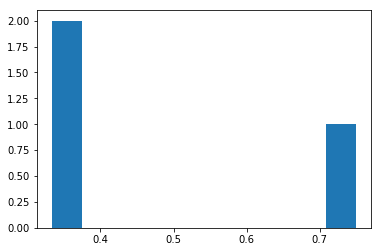

In [25]:
plt.hist(impact_km)
plt.show()

In [102]:
tst[:10]

,ID,Fwy,Dir,District,County,City,State_PM,Abs_PM,Latitude,Longitude,Length,Type,Lanes,Name,User_ID_1,User_ID_2,User_ID_3,User_ID_4
9,715996,5,S,7,37,44000.0,37.3,153.870,34.243318,-118.421080,0.275,ML,6,OSBORNE 1,3486,NaN,NaN,NaN
11,716010,5,S,7,37,69088.0,R49.5,165.847,34.368149,-118.558850,0.600,ML,4,S OF WABUSKA,2089,NaN,NaN,NaN
12,716016,5,S,7,37,69088.0,R54.2,170.547,34.431273,-118.588555,0.650,ML,4,RYE CANYON,4379,NaN,NaN,NaN
59,716271,71,S,7,37,58072.0,R.84,0.501,34.067080,-117.804144,1.218,ML,1,RIDGEWAY ST,2560,NaN,NaN,NaN
68,716328,101,S,7,37,44000.0,2.08,3.428,34.067067,-118.254688,0.365,ML,4,EDGEWARE,2076,NaN,NaN,NaN
69,716331,101,S,7,37,44000.0,2.56,3.908,34.070002,-118.262279,0.355,ML,4,GLENDALE,3004,NaN,NaN,NaN
71,716339,101,S,7,37,44000.0,4.2,5.548,34.078365,-118.288977,0.525,ML,4,VERMONT,3002,NaN,NaN,NaN
73,716390,101,S,7,37,90310.0,29.5,30.832,34.149135,-118.672472,0.790,ML,5,CALABASAS,2634,NaN,NaN,NaN
74,716391,101,S,7,37,90310.0,30,31.332,34.151032,-118.680765,0.760,ML,4,TRUCK STOP,2635,NaN,NaN,NaN
75,716392,101,S,7,37,90310.0,31.02,32.352,34.148836,-118.697394,0.600,ML,4,LAS VIRGENES 1,4176,NaN,NaN,NaN


In [40]:
def plot_impact_of_distance(d_range, bins, incidents, series, stations):
    mean_array = np.array([])
    fig, axes = plt.subplots(2, int(bins/2), figsize=[15,7])
    i=0
    for d in np.linspace(d_range[0], d_range[1], bins):
        impact = calculate_affect_degree(incidents, series, stations, d)
        impact = impact[impact != -1.0]
        mean_array = np.append(mean_array, impact.mean())
        axes[int(2*i/bins)][int(i%(bins/2))].hist(impact)
        axes[int(2*i/bins)][int(i%(bins/2))].set_title('{:.3f}'.format(d))
        i += 1
    plt.show()
    return mean_array

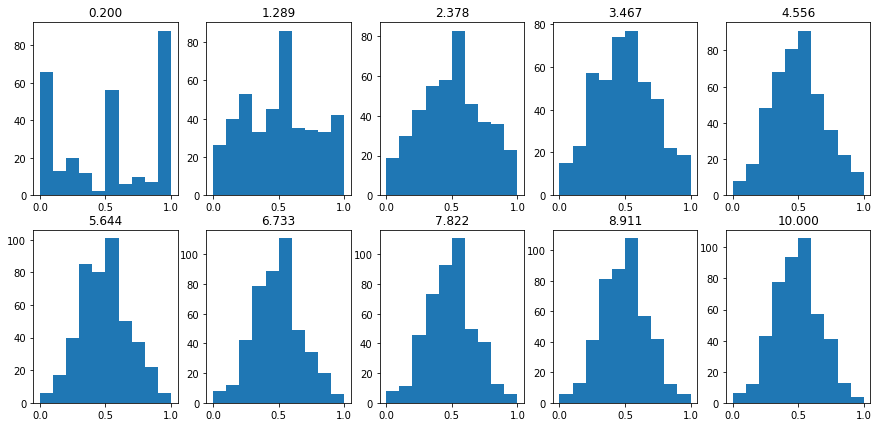

In [41]:
m_ar = plot_impact_of_distance([.2, 10], 10, data_inc_d07, data_srs_no_null, stations_active)

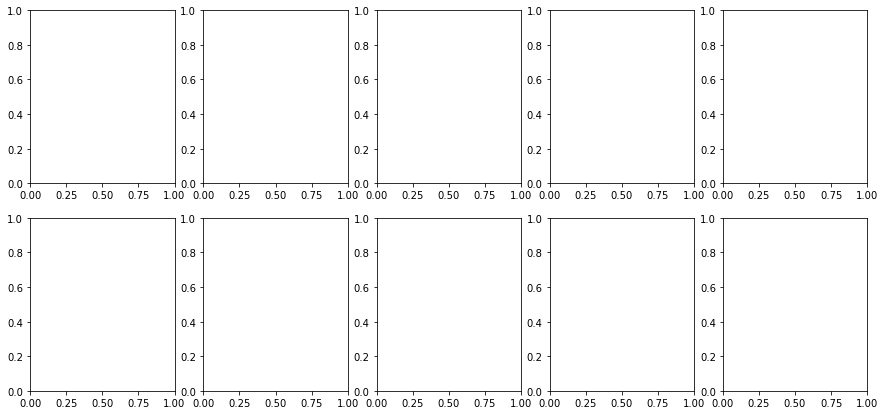

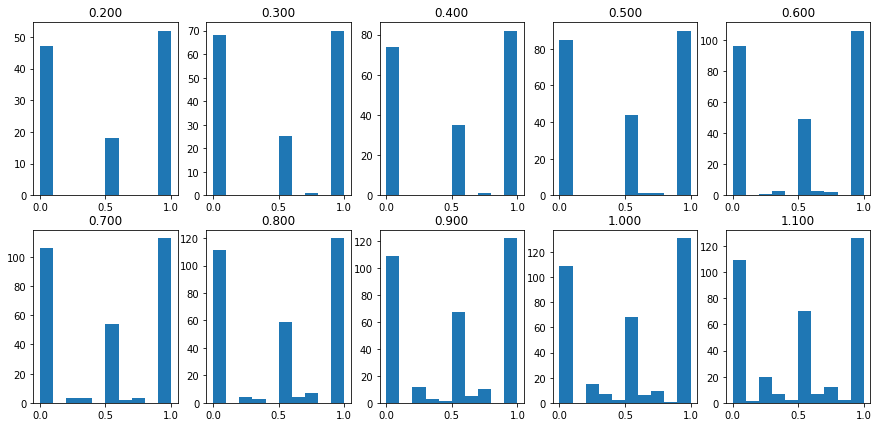

In [112]:
m_ar = plot_impact_of_distance([.2, 1.1], 10, data_inc_d07, data_srs_no_null, stations_active)

In [65]:
data_inc_d07.drop(labels=['CC_Code', 'TBxy', 'Timestamp', 'Zoom_Map', 'Severity'], axis=1)[data_inc_d07['Freeway']==605]

,index,IncidentID,Incident_No,Description,Location,Area,Latitude,Longitude,District,CountryFIPS_ID,CityFIPS_ID,Freeway,Freeway_direction,State_postmile,Absolute_postmile,Duration
0,7,17520466,171011,CLOSURE of a Road,I605 N / Beverly Blvd Onr,Santa Fe Springs,34.006906,-118.060551,7,37.0,56924.0,605,N,R14.648,16.7,93.0
20,78,17520576,171011,1182-Trfc Collision-No Inj,I605 S / I5 N I605 S Con,Santa Fe Springs,33.941465,-118.096574,7,37.0,19766.0,605,S,R9.648,11.7,65.0
33,135,17520653,171011,1183-Trfc Collision-Unkn Inj,I605 S / Beverly Blvd E Ofr,Santa Fe Springs,34.006196,-118.061729,7,37.0,56924.0,605,S,R14.548,16.6,20.0
70,242,17520803,171011,1182-Trfc Collision-No Inj,I605 S / Telegraph Rd,Santa Fe Springs,33.949800,-118.092046,7,37.0,69154.0,605,S,R10.248,12.3,19.0
95,329,17520920,171011,1125-Traffic Hazard,I605 N / So Sr60,Santa Fe Springs,34.032342,-118.029106,7,37.0,36490.0,605,N,R17.248,19.3,29.0
98,332,17520923,171011,ANIMAL-Live or Dead Animal,I605 S / South St,Santa Fe Springs,33.858344,-118.096283,7,37.0,12552.0,605,S,R3.748,5.8,22.0
116,376,17520982,171011,1183-Trfc Collision-Unkn Inj,I605 N / South St,Santa Fe Springs,33.858358,-118.096011,7,37.0,12552.0,605,N,R3.748,5.8,18.0
118,383,17520990,171011,1183-Trfc Collision-Unkn Inj,I605 S / I10,LAFSP,34.065158,-118.000227,7,37.0,3666.0,605,S,R20.148,22.2,15.0
121,391,17521000,171011,1183-Trfc Collision-Unkn Inj,I605 N / Valley Blvd,LAFSP,34.054262,-118.004172,7,37.0,NaN,605,N,R19.448,21.5,-1.0
122,392,17521001,171011,1183-Trfc Collision-Unkn Inj,I605 N / Valley Blvd,East LA,34.054262,-118.004172,7,37.0,NaN,605,N,R19.448,21.5,5.0


Hot spot station analysis

In [558]:
nearest_accidents = data_d07[data_d07.apply(lambda x: vincenty((x['Latitude'], x['Longitude']), station_coords).kilometers < 5, axis=1)]